<a href="https://colab.research.google.com/github/emyesme/CalcificationDetection/blob/feature-pm/ML_structure_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os 

#first put a shortcut in your drive to the image processing folder

DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results')


print(os.listdir(DATA_DIR))

results_file = os.listdir(DATA_DIR)

['first_partial', 'second_partial', 'patch_problem', '20586908_6c613a14b80a8591_MG_R_CC_ANON_features.csv', '20586934_6c613a14b80a8591_MG_L_CC_ANON_features.csv', '20586960_6c613a14b80a8591_MG_R_ML_ANON_features.csv', '20586986_6c613a14b80a8591_MG_L_ML_ANON_features.csv', '20587054_b6a4f750c6df4f90_MG_R_CC_ANON_features.csv', '20587080_b6a4f750c6df4f90_MG_R_ML_ANON_features.csv', '20587148_fd746d25eb40b3dc_MG_R_CC_ANON_features.csv', '20587174_fd746d25eb40b3dc_MG_L_CC_ANON_features.csv', '20587200_fd746d25eb40b3dc_MG_R_ML_ANON_features.csv', '20587226_fd746d25eb40b3dc_MG_L_ML_ANON_features.csv', '20587294_e634830794f5c1bd_MG_R_CC_ANON_features.csv', '20587320_e634830794f5c1bd_MG_L_CC_ANON_features.csv', '20587346_e634830794f5c1bd_MG_R_ML_ANON_features.csv', '20587372_e634830794f5c1bd_MG_L_ML_ANON_features.csv', '20587466_d571b5880ad2a016_MG_L_CC_ANON_features.csv', '20587492_d571b5880ad2a016_MG_R_ML_ANON_features.csv', '20587518_d571b5880ad2a016_MG_L_ML_ANON_features.csv', '20587544_d5

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [4]:
def read_results(path):
  dfs= pd.DataFrame()
  for result in results_file[3:]:
    try:
      df = pd.read_csv(path+'/'+result)
      dfs = dfs.append(df)
    except:
      print("Empty file ", result)
  return dfs

In [5]:
dfs = read_results(DATA_DIR)

In [6]:
dfs.shape

(7536, 26)

In [7]:
dfs.label.value_counts()

0    5578
1    1958
Name: label, dtype: int64

In [8]:
dfs.label.value_counts().idxmax()

0

# **Preprocessing**

In [28]:
# We will balance data randomly taking  the same amount of 0 and 1 label inputs. There are several options to manage unbalanced data,
# this is just one approach, we should try different approaches.
# https://towardsdatascience.com/comparing-different-classification-machine-learning-models-for-an-imbalanced-dataset-fdae1af3677f
def rus(dfs):
  df_0 = dfs.loc[dfs.label == dfs.label.value_counts().idxmax()].sample(min(dfs.label.value_counts()), random_state = 1)
  dfs_eq = df_0.append(dfs.loc[dfs.label == dfs.label.value_counts().idxmin()])
  print("Length of balanced data: ", len(dfs_eq))
  return dfs_eq

In [26]:
def plotFeatures(data):
  #plot the scatter matrix
  pd.plotting.scatter_matrix(data,figsize=(25,25))
  #correlation plot
  corr = data.corr()
  f, ax = plt.subplots(figsize=(25, 25))
  sns.heatmap(corr,annot=True)

In [12]:
def standardScaler(X_train, X_test):
  standard_scaler = preprocessing.StandardScaler()
  X_train = standard_scaler.fit_transform(X_train)
  X_test = standard_scaler.transform(X_test)
  return X_train, X_test

# **Feature Engineering**

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


In [14]:
def featureSelectionTrees(estimators, X_train, y_train, X_test):
  clf = ExtraTreesClassifier(n_estimators=estimators)
  clf = clf.fit(X_train, y_train)
  model = SelectFromModel(clf, prefit=True)
  X_train = model.transform(X_train)
  X_test = model.transform(X_test)
  return X_train, X_test

In [38]:
def pcaAnalysis(components, X_train, X_test):
  pca = PCA(components)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  print("PCA variance ratio: ", pca.explained_variance_ratio_)
  print("Total variance Explained by PCA: ", sum(pca.explained_variance_ratio_))
  return X_train, X_test

In [16]:
def selectFeaturesChi(k, X_train, X_test, y_train):
  sel = SelectKBest(chi2, k=k)
  sel.fit(X_train, y_train)
  X_train = sel.transform(X_train)
  X_test = sel.transform(X_test)
  return X_train, X_test

# **Classification**

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree

import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2



In [34]:
def KNN(neighbors, X_train, X_test, y_train, y_test, data, labels):
  neigh = KNeighborsClassifier(n_neighbors=neighbors)
  y_pred = neigh.fit(X_train, y_train).predict(X_test)
  cvScore = cross_val_score(neigh, data, labels, cv=10)
  print(cvScore)
  print("Mean CV_score accuracy: ", np.mean(cvScore))

In [35]:
def DecisionTree(X_train, X_test, y_train, y_test, data, labels):
  clf = tree.DecisionTreeClassifier()
  y_pred = clf.fit(X_train, y_train).predict(X_test)
  cvScore = cross_val_score(clf, data, labels, cv=10)
  print(cvScore)
  print("Mean CV_score accuracy: ", np.mean(cvScore))


In [21]:
# This is an example of how to use a Pipe inside a function we are training, as done in Challenge 3 by the professor
def SVC_linear(n_values, lower_value_C, higher_value_C, base, data, labels):
  #Let's apply a stratified 10-fold cross validation
  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

  #Let's build a pipeline with only a scaler and a linear SVM
  pipe = Pipeline([('scaler', StandardScaler()), ('classifier',SVC(kernel='linear'))])

  #Let's build a structure for the grid search with a set of parameters for the techniques in the pipeline
  #Be careful to the double underscore between the name you chose in the pipeline and the name of the parameter
  #Be careful also to the function logspace for the range of the C values
  parameters={'classifier__C': np.logspace(lower_value_C, higher_value_C, num=n_values,base=base)}
  print(parameters)

  #Let's apply the grid search function
  grid_search = GridSearchCV(pipe, parameters, cv=cv)
  #Let's train and test the learning system
  grid_search.fit(data, labels)

  #Here we just print the best accuracy and the corresponding values for the parameters
  print("The best parameters are %s with an accuracy of %0.4f"%(grid_search.best_params_, grid_search.best_score_))


# **Main**

In [39]:
def main():
  #Reading data
  dfs = read_results(DATA_DIR)

  #Preprocessing steps
  #Manage unbalanced data
  dataBalanced = rus(dfs) #Random majority undersampling

  labels = dataBalanced['label']
  data = dataBalanced.drop(['name', 'label'], axis=1)

  #Plot features 
  plotFeatures(data)

  #Obtain train-test datasets
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)  

  # Normalization steps
  X_train, X_test = standardScaler(X_train, X_test)

  #Feature Engineering - PCA, LDA, choose-k, etc
  X_train, X_test = pcaAnalysis(10, X_train, X_test)


  #Classification
  DecisionTree(X_train, X_test, y_train, y_test, data, labels)



  


Length of balanced data:  3916
PCA variance ratio:  [0.54248852 0.1586419  0.12351345 0.0574043  0.04646453 0.0323135
 0.01740931 0.01002289 0.00472001 0.00232615]
Total variance Explained by PCA:  0.995304551866029
[0.66581633 0.67857143 0.66326531 0.66326531 0.67602041 0.67602041
 0.62659847 0.56521739 0.62404092 0.69053708]
Mean CV_score accuracy:  0.6529353045566052


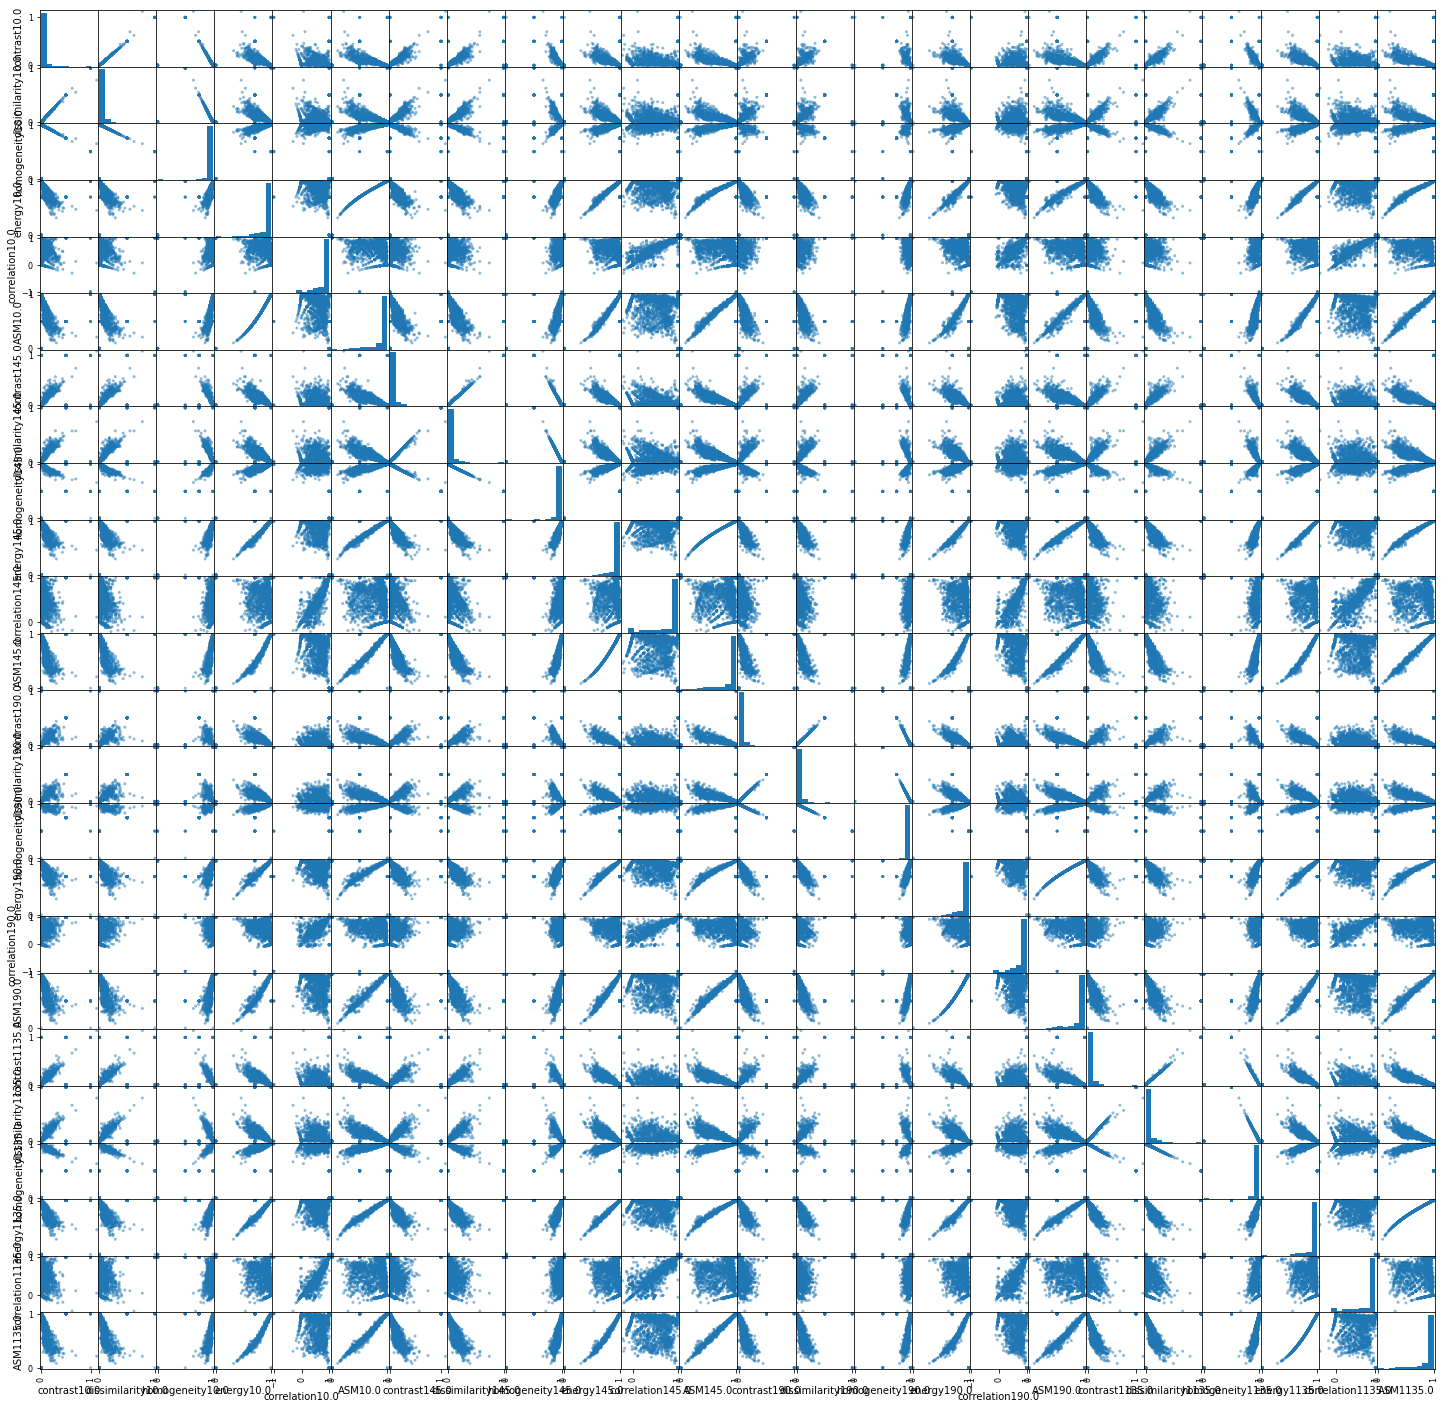

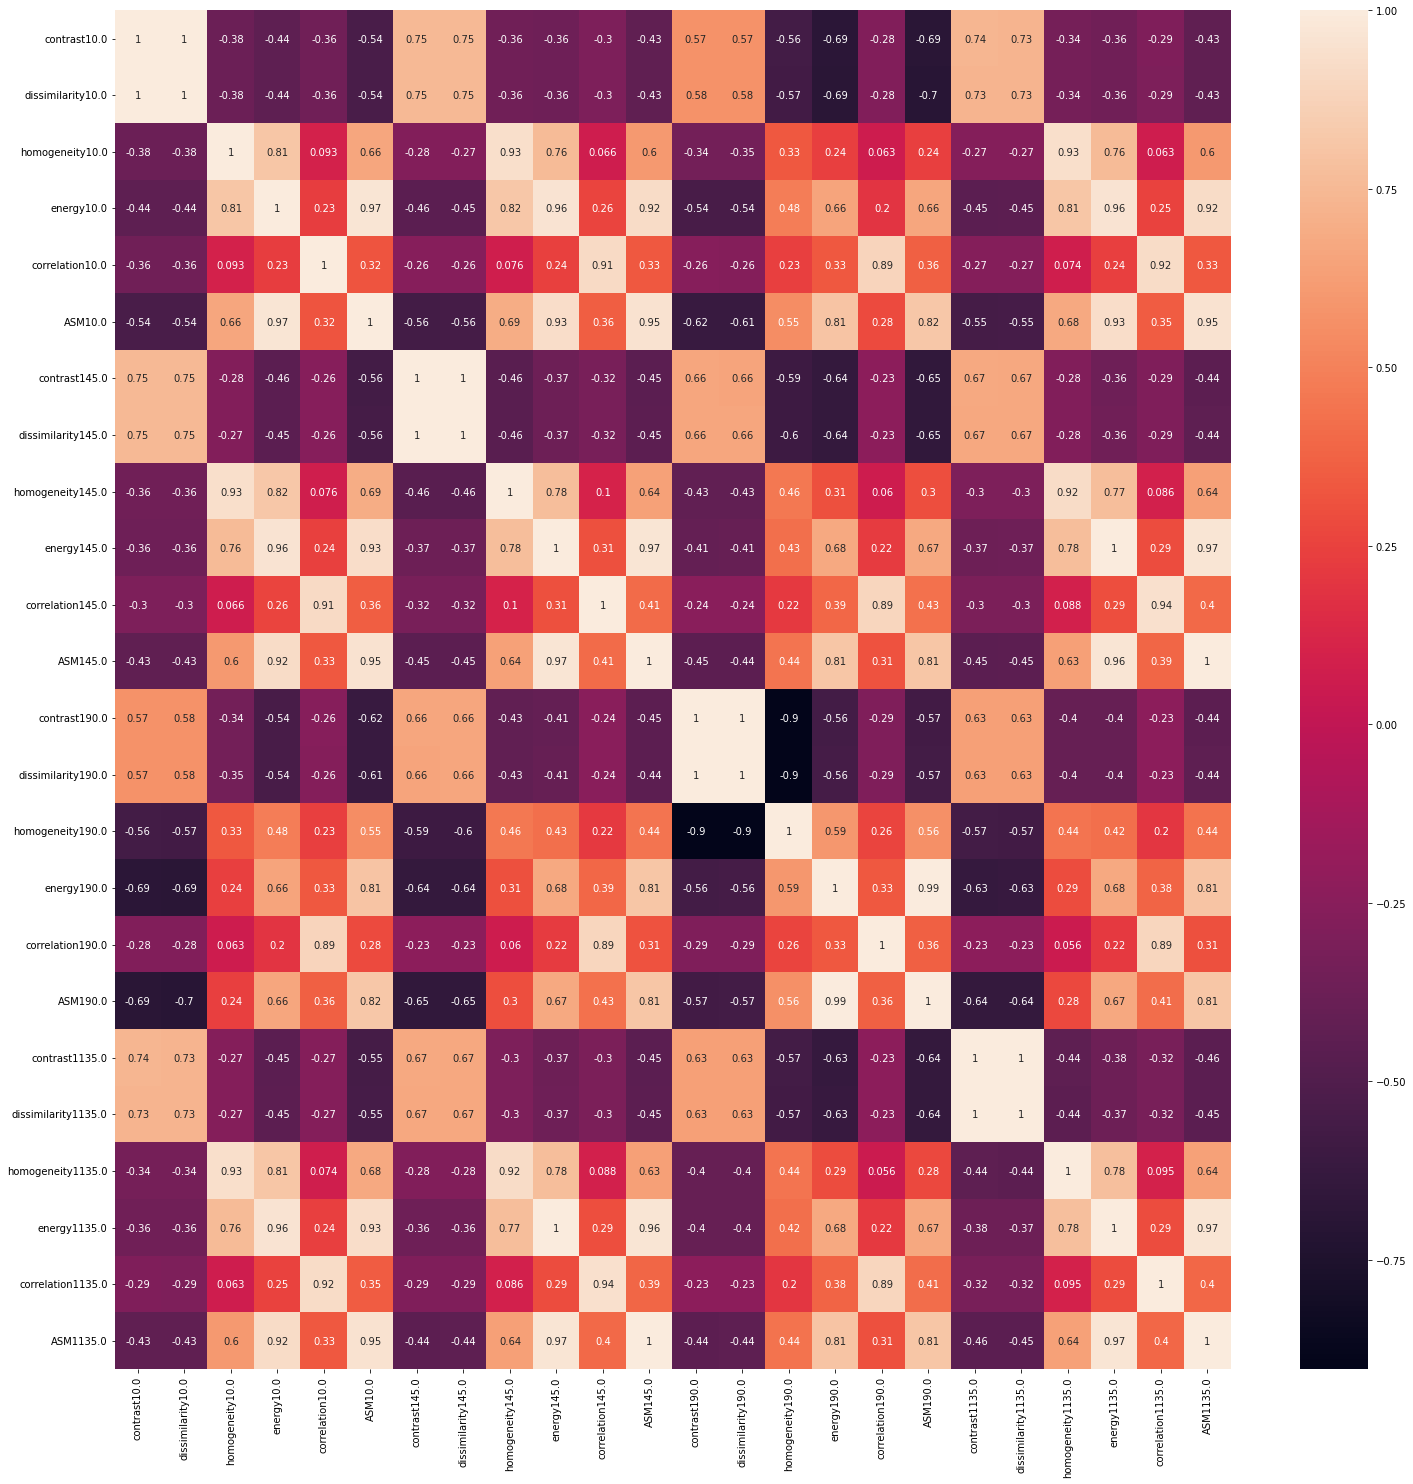

In [40]:
if __name__== "__main__":
  main()

In [ ]:
# When we find the best fit, we can put everything into a pipeline

# pipe = Pipeline([('standard', StandardScaler()),
#                  ('classifier', KNeighborsClassifier(n_neighbors=5))])

# pipe.fit(X_train, y_train)
# score = pipe.predict(X_test)
# accuracy_score(y_test, score)